# Part1 annotation

In [51]:
!pip install transformers
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import nltk
from nltk.corpus import stopwords
from nltk import BigramCollocationFinder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import pickle
import re
from transformers import pipeline
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split

In [89]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [52]:
#Remove Stop Words Function
def rem_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

In [53]:
stemmer = PorterStemmer()
def stemming(text):
  tokens = text.split()
  ret = []
  for token in tokens:
    ret.append(stemmer.stem(token))
  return ' '.join(ret)


In [54]:
positive_words = [
    "amazing", "awesome", "best", "beautiful", "brilliant", "breathtaking", "charming",
    "delightful", "enjoyable", "excellent", "exceptional", "fantastic", "friendly", "fun",
    "great", "happy", "impressive", "incredible", "love", "magnificent", "marvelous",
    "nice", "outstanding", "perfect", "pleasant", "pleased", "positive", "recommend",
    "satisfied", "spectacular", "splendid", "stunning", "superb", "terrific", "thrilled",
    "top-notch", "unbelievable", "wonderful", "wonderfully", "appreciate", "awesome",
    "celebrate", "cheerful", "commend", "congratulate", "creative", "delighted",
    "elegant", "enchanting", "enjoyed", "enthusiastic", "fabulous", "fantastic",
    "favorable", "friendly", "glorious", "good", "great", "happy", "harmonious",
    "hopeful", "impressive", "inspired", "joyful", "kind", "lovely", "loving",
    "marvelous", "motivated", "nice", "outstanding", "perfect", "pleasant",
    "positive", "praise", "prosperous", "remarkable", "rewarding", "satisfied",
    "sensational", "serene", "skillful", "spectacular", "splendid", "successful",
    "superb", "supportive", "terrific", "thankful", "thrilled", "tranquil", "triumphant"
]

negative_words = [
    "awful", "bad", "boring", "disappointing", "disappointed", "horrible", "mediocre",
    "negative", "poor", "terrible", "unpleasant", "worst", "annoyed", "awful", "bad",
    "bitter", "broken", "confused", "crappy", "crappy", "cruel", "cry", "depressed",
    "difficult", "disgusted", "distressed", "dreadful", "dull", "embarrassed", "envious",
    "fail", "fear", "filthy", "foolish", "frustrated", "gloomy", "greedy", "grim",
    "hateful", "heartbroken", "helpless", "horrible", "hurt", "ill", "immoral",
    "insecure", "insulting", "jealous", "lazy", "lonely", "miserable", "nasty",
    "naughty", "nervous", "noisy", "obnoxious", "offended", "outraged", "painful",
    "pessimistic", "poor", "prejudiced", "regretful", "repulsive", "resentful", "sad",
    "scared", "selfish", "shameful", "shocked", "sick", "sinister", "sorrow", "stressed",
    "stupid", "terrible", "threatened", "tired", "tragic", "ugly", "uncomfortable",
    "unhappy", "unpleasant", "upset", "useless", "vicious", "violent", "vulgar",
    "weak", "wicked", "worried", "worthless", "wretched", "wrong"
]

neutral_words = [
    "average", "common", "decent", "fair", "fine", "medium", "moderate", "ordinary",
    "passable", "regular", "satisfactory", "standard", "typical", "unremarkable", "usual",
    "adequate", "balanced", "basic", "commonplace", "consistent", "customary",
    "dependable", "expected", "familiar", "general", "habitual", "mainstream", "middle",
    "middling", "moderate", "normal", "okay", "plain", "predictable", "routine",
    "run-of-the-mill", "steady", "traditional", "unexceptional", "uniform", "unspectacular",
    "workmanlike", "acceptable", "average", "balanced", "banal", "boring", "careful",
    "cautious", "characteristic", "collective", "commonplace", "conformist", "conservative",
    "consistent", "constant", "customary", "dependable", "disciplined", "dispassionate",
    "efficient", "everyday", "habitual", "homogeneous", "mainstream", "methodical",
    "middle-of-the-road", "monotonous", "neutral", "nonpartisan", "obvious", "ordained",
    "orderly", "plain", "practical", "predictable", "prescribed", "regular", "reliable",
    "repetitive", "routine", "sensible", "serious", "settled", "staid", "steady",
    "tedious", "unbiased", "unvarying", "usual"
]



In [55]:
def remove_long_comments(df):
    max_seq_length = 512
    df = df[df['comments'].str.len() <= max_seq_length]
    return df


In [56]:
def clean_text(text):
    #Remove characters that are not a-z, A-Z, or spaces
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    #To lowercase
    cleaned_text = cleaned_text.lower()
    #Replace multiple consecutive spaces with a single space
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    #Strip leading and trailing spaces
    cleaned_text = cleaned_text.strip()
    #Remove Stopwords
    cleaned_text = rem_stopwords(cleaned_text)
    return cleaned_text if cleaned_text else np.nan

In [57]:
def classify_text(text):

    #word = re.findall(r'\b\w+\b',text)  # Tokenize the text
    positive_count = sum(word in text for word in positive_words)
    negative_count = sum(word in text for word in negative_words)
    neutral_count = sum(word in text for word in neutral_words)

    # Determine the category based on the highest count
    if (positive_count > negative_count and positive_count > neutral_count):
        return 'Positive'
    elif (negative_count > positive_count and negative_count > neutral_count):
        return 'Negative'
    else:
        return 'Neutral'


# 2019

## Pre-processing

In [58]:
nltk.download('stopwords')
path_2019_april = '/content/gdrive/MyDrive/data/2019/april/reviews.csv'
path_2019_feb = '/content/gdrive/MyDrive/data/2019/febrouary/reviews.csv'  # Corrected the file name
path_2019_mar = '/content/gdrive/MyDrive/data/2019/march/reviews.csv'
months = ["april", "february", "march"]
csv_paths = [path_2019_april,path_2019_feb,path_2019_mar]
csv_files_annotated = ["annotated_april_2019.csv","annotated_feb_2019.csv","annotated_mar_2019.csv"]
selected_columns = ['id','comments']

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)        # Auto-detect the width
pd.set_option('display.max_colwidth', None) # Display full column content

#Cleaning
print("Starting Cleaning")
for i, file in enumerate(csv_paths):
  df = pd.read_csv(csv_paths[i])

  df = df[[col for col in selected_columns if col in df.columns]]

  df = df.drop_duplicates(subset='id')
  df = df.drop_duplicates(subset='comments')
  df['comments'] = df['comments'].astype('str')
  df = df[df['comments'].notna()]
  df['comments'] = df['comments'].apply(clean_text)
  df = df[df['comments'].notna()]
  df = remove_long_comments(df)
  df = df.reset_index(drop=True)
  print(f"Clean {months[i]} length: {len(df)} ")
  df.to_csv(csv_files_annotated[i], index=False)
print("Cleaning is done")

df = pd.read_csv(csv_files_annotated[0])
print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Starting Cleaning
Clean april length: 249635 
Clean february length: 241758 
Clean march length: 243644 
Cleaning is done
         id  \
0    271535   
1   1994237   
2   4678609   
3  12502994   
4  19482948   

                                                                                                                                                                                                                                                                                                                                                                                                                                    comments  
0                                                                                                                                                                                                                                                                       apartment wonderful fully equiped beautiful decor comfortable verry clean would stay possibl

In [59]:
#Manual classification based on lists of words
print("Starting Manual Classification")
for i, file in enumerate(csv_files_annotated):
  df = pd.read_csv(file)
  df = df[df['comments'].notna()]
  df['sentiment'] = df['comments'].apply(classify_text)
  df.to_csv(file, index=False)
print("Manual Classification is done")

Starting Manual Classification
Manual Classification is done


In [60]:
#Pick 200 random samples from each of the tree labels, for each month
print("Sampling")
for i, file in enumerate(csv_files_annotated):
  df = pd.read_csv(file)
  positive_sample = df[df['sentiment'] == 'Positive'].sample(n=200, random_state=42)
  negative_sample = df[df['sentiment'] == 'Negative'].sample(n=200, random_state=42)
  neutral_sample = df[df['sentiment'] == 'Neutral'].sample(n=200, random_state=42)
  # Combine the samples into one DataFrame
  sampled_df = pd.concat([positive_sample, negative_sample, neutral_sample])
  # Shuffle the resulting DataFrame
  sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
  print(f"Sampled {months[i]} length: {len(sampled_df)} ")
  sampled_df.to_csv(file,index=False)


Sampling
Sampled april length: 600 
Sampled february length: 600 
Sampled march length: 600 


In [61]:
#Drop the category column and annotate the samples using Roberta
print("Roberta Annotation Starting")

for i, file in enumerate(csv_files_annotated):
  df = pd.read_csv(file)
  df = df.drop('sentiment', axis=1)
  to_list = df['comments'].tolist()
  classifier = pipeline("text-classification", model="j-hartmann/sentiment-roberta-large-english-3-classes")
  results = classifier(to_list)
  sentiments = [(lambda res: res['label'])(res) for res in results]
  df['sentiment'] = sentiments
  df.to_csv(file, index=False)
print("Finished")

Roberta Annotation Starting


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequence

Finished


# 2023

## Pre-Processing

In [62]:
nltk.download('stopwords')
path_2023_june = '/content/gdrive/MyDrive/data/2023/june/reviews.csv'
path_2023_march = '/content/gdrive/MyDrive/data/2023/march/reviews.csv'  # Corrected the file name
path_2023_september = '/content/gdrive/MyDrive/data/2023/september/reviews.csv'
months = ["june", "march", "september"]
csv_paths = [path_2023_june , path_2023_march, path_2023_september]
csv_files_annotated = ["annotated_june_2023.csv","annotated_march_2023.csv","annotated_september_2023.csv"]
selected_columns = ['id','comments']

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)        # Auto-detect the width
pd.set_option('display.max_colwidth', None) # Display full column content

#Cleaning
print("Starting Cleaning")
for i, file in enumerate(csv_paths):
  df = pd.read_csv(csv_paths[i])
  df = df[[col for col in selected_columns if col in df.columns]]
  df = df.drop_duplicates(subset='id')
  df = df.drop_duplicates(subset='comments')
  df['comments'] = df['comments'].astype('str')
  df = df[df['comments'].notna()]
  df['comments'] = df['comments'].apply(clean_text)
  df = df[df['comments'].notna()]
  df = remove_long_comments(df)
  df = df.reset_index(drop=True)
  print(f"Clean {months[i]} length: {len(df)} ")
  df.to_csv(csv_files_annotated[i], index=False)
print("Cleaning is done")

df = pd.read_csv(csv_files_annotated[0])
print(df.head())

Starting Cleaning


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Clean june length: 488368 
Clean march length: 452554 
Clean september length: 488368 
Cleaning is done
         id  \
0    271535   
1   1994237   
2  12184199   
3  13197921   
4  13393565   

                                                                                                                                                                                                                                                                                                                                                                                                                                    comments  
0                                                                                                                                                                                                                                                                       apartment wonderful fully equiped beautiful decor comfortable verry clean would stay possibly another host pro

In [63]:
#Manual classification based on lists of words
print("Starting Manual Classification")
for i, file in enumerate(csv_files_annotated):
  df = pd.read_csv(file)
  df = df[df['comments'].notna()]
  df['sentiment'] = df['comments'].apply(classify_text)
  df.to_csv(file, index=False)
print("Manual Classification is done")

Starting Manual Classification
Manual Classification is done


In [64]:
#Pick 200 random samples from each of the tree labels, for each month
print("Sampling")
for i, file in enumerate(csv_files_annotated):
  df = pd.read_csv(file)
  positive_sample = df[df['sentiment'] == 'Positive'].sample(n=200, random_state=42)
  negative_sample = df[df['sentiment'] == 'Negative'].sample(n=200, random_state=42)
  neutral_sample = df[df['sentiment'] == 'Neutral'].sample(n=200, random_state=42)
  # Combine the samples into one DataFrame
  sampled_df = pd.concat([positive_sample, negative_sample, neutral_sample])
  # Shuffle the resulting DataFrame
  sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
  print(f"Sampled {months[i]} length: {len(sampled_df)} ")
  sampled_df.to_csv(file, index=False)


Sampling
Sampled june length: 600 
Sampled march length: 600 
Sampled september length: 600 


In [65]:
#Drop the category column and annotate the samples using Roberta
print("Roberta Annotation Starting")

for i, file in enumerate(csv_files_annotated):
  df = pd.read_csv(file)
  df = df.drop('sentiment', axis=1)
  to_list = df['comments'].tolist()
  classifier = pipeline("text-classification", model="j-hartmann/sentiment-roberta-large-english-3-classes")
  results = classifier(to_list)
  sentiments = [(lambda res: res['label'])(res) for res in results]
  df['sentiment'] = sentiments
  df.to_csv(file, index=False)
print("Finished")

Roberta Annotation Starting


Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequence

Finished


## Histograms

In [66]:
#Concatenation by year
april_2019 = pd.read_csv('/content/annotated_april_2019.csv')
feb_2019 = pd.read_csv('/content/annotated_feb_2019.csv')
mar_2019 = pd.read_csv('/content/annotated_mar_2019.csv')
train_2019 = pd.concat([april_2019, feb_2019, mar_2019], axis=0)
train_2019.reset_index(drop=True, inplace=True)
train_2019.to_csv('train_2019.csv', index=False)


june_2023 = pd.read_csv('/content/annotated_june_2023.csv')
march_2023 = pd.read_csv('/content/annotated_march_2023.csv')
september_2023 = pd.read_csv('/content/annotated_september_2023.csv')
train_2023 = pd.concat([june_2023, march_2023, september_2023], axis=0)
train_2023.reset_index(drop=True, inplace=True)
train_2023.to_csv('train_2023.csv', index=False)

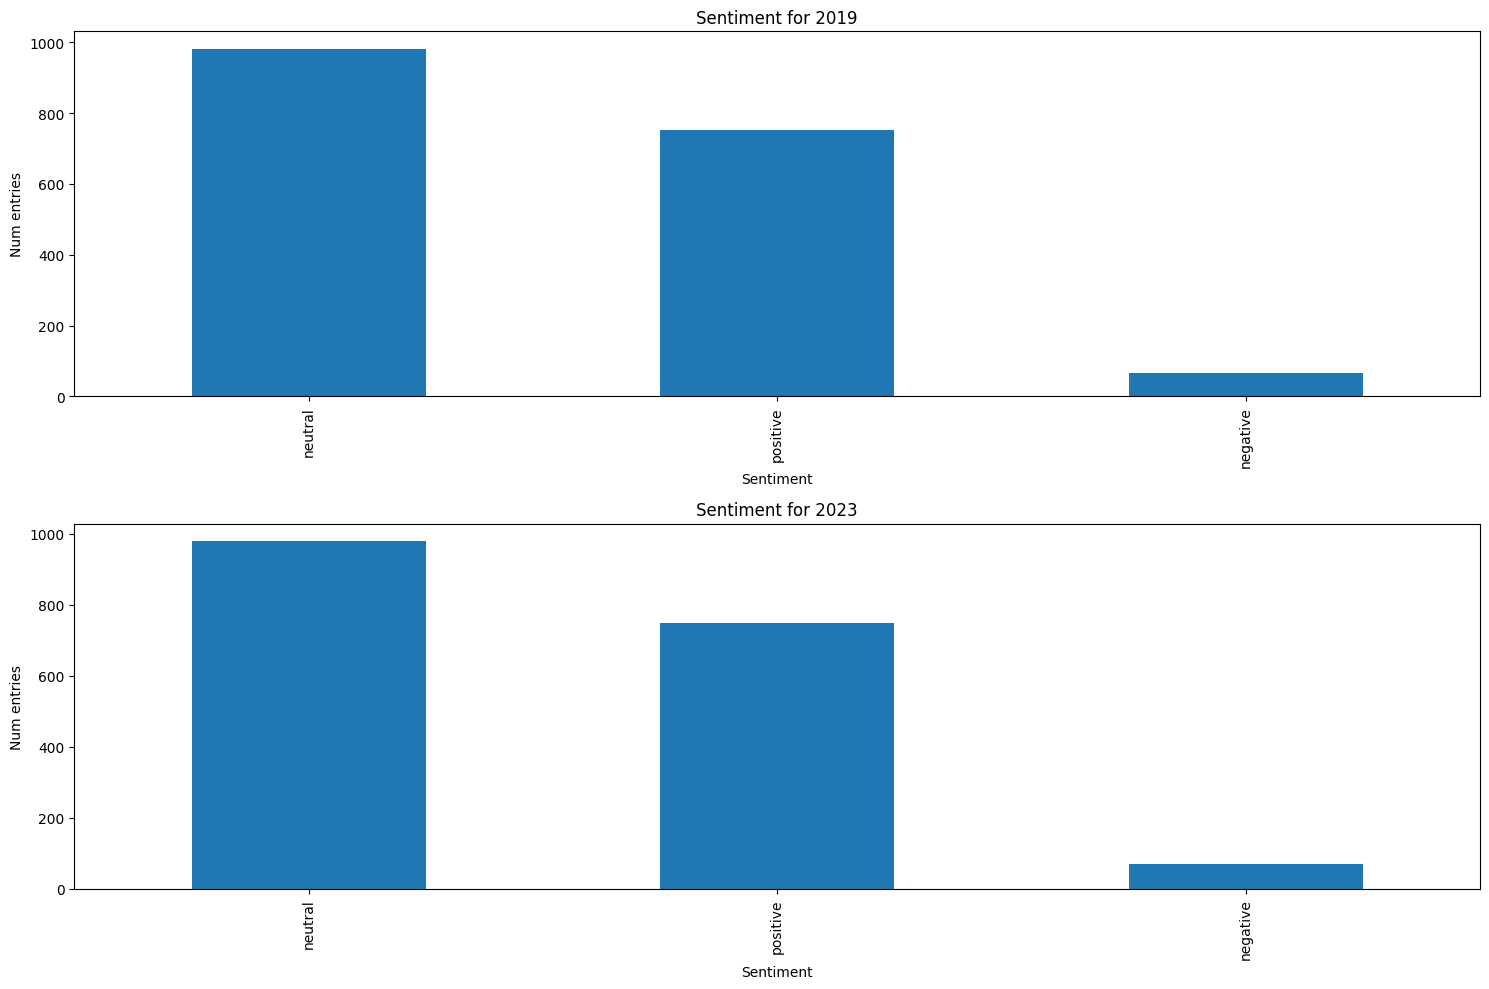

In [67]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Plot the histogram

#Entries per neighbourhood 2019
counts1 = train_2019['sentiment'].value_counts()

#Entries per neighbourhood 2023
counts2 = train_2023['sentiment'].value_counts()

# Create a figure with two subplots arranged horizontally
fig, axs = plt.subplots(2, 1, figsize=(15, 10))


counts1.plot(kind='bar', ax=axs[0])
axs[0].set_xlabel('Sentiment')
axs[0].set_ylabel('Num entries')
axs[0].set_title('Sentiment for 2019')

counts2.plot(kind='bar', ax=axs[1])
axs[1].set_xlabel('Sentiment')
axs[1].set_ylabel('Num entries')
axs[1].set_title('Sentiment for 2023')


# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

# Part 2

In [70]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
import nltk
nltk.download('punkt')
from numpy import dot
from numpy.linalg import norm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [68]:
path = '/content/train_2023.csv'

In [69]:
path = '/content/train_2019.csv'

In [71]:
#Function to create a word2vec model for our dataset
def create_word2vec_model(corpus):
    data = []
    for (i, comment) in enumerate(corpus['comments'].values):
        tokenized_text = []
        for word in word_tokenize(comment):
            tokenized_text.append(word)
        data.append(tokenized_text)
    model = Word2Vec(data, min_count = 1, vector_size = 100, window = 5, sg = 1) #Create a word2vec model using skip grams
    name = "word2vec.pickle"
    with open(name, 'wb') as f:
        pickle.dump(model, f)
    return name
#test prints
train_model = pd.read_csv(path)
model_name = create_word2vec_model(train_model)

with open(model_name, 'rb') as handle:
  model = pickle.load(handle)
vector = model.wv
print(vector['friendly'])
sims = model.wv.most_similar('friendly', topn=10)  # get other similar words
print(sims)

[-0.1529715  -0.1714749  -0.09071559 -0.21070436 -0.07963217 -0.386563
  0.21331708  0.83602846 -0.18935113 -0.2821215   0.13458973 -0.21651483
 -0.2187579   0.23879611 -0.20055139 -0.11625499  0.01701817 -0.36478534
  0.20532855 -0.4870936   0.10024755  0.21061927  0.1697456   0.40894303
  0.11513955  0.01973326 -0.14191182 -0.12002063 -0.26810828 -0.31889638
  0.19901986  0.43097213  0.13094865 -0.29180408 -0.13892534  0.18407132
 -0.07413446 -0.53338724 -0.39602178 -0.48999703  0.01337927 -0.06661477
 -0.17602958 -0.10729538  0.27534625 -0.26935348 -0.30301496  0.02747004
  0.11662741 -0.01785946 -0.24225667 -0.57300717 -0.24380556 -0.16672795
 -0.03987391 -0.0635833   0.08239433 -0.15780702  0.04597731  0.22817676
 -0.31269175  0.22445384 -0.03545289 -0.18066163 -0.6435592   0.32892033
  0.5543483   0.38515624 -0.28973386  0.24559145 -0.22615246  0.22751161
  0.03399247 -0.17727385  0.40842867  0.02957949  0.33438557 -0.3132001
 -0.31912038  0.02579666 -0.30120847  0.00516078 -0.25

In [72]:
#Function to vectorize the data for our model
def vectorize(df):
    X = []
    Y = []
    # Sentiments mapped to numbers
    df['Sentiment_Num'] = df.sentiment.map({
    'positive':0,
    'neutral':1,
    'negative':2

    })

    sentiment = list(df['Sentiment_Num'])
    model_name = create_word2vec_model(df)
    with open(model_name, 'rb') as handle:
        model = pickle.load(handle)
    for (i, comment) in enumerate(df['comments'].values):
        featureVec = np.zeros(100,dtype="float32")
        nwords = 0
        #Converting Index2Word which is a list to a set for better speed in the execution.
        index2word_set = set(model.wv.index_to_key)
        for word in word_tokenize(comment):
            if word in index2word_set:
                nwords = nwords + 1
                featureVec = np.add(featureVec,model.wv[word])
        # Dividing the result by number of words to get average
        if(nwords > 0):
            featureVec = np.divide(featureVec, nwords)
        X.append(featureVec) #we keep the mean
        Y.append(sentiment[i])
    return(X,Y)

#Loading processed data and vectorization

stemmed = pd.read_csv(path)
(X,Y) = vectorize(stemmed)
print("Done")

Done


In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Xtrain, Xtest , Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=69)

In [74]:
vm_classifier = SVC(kernel='linear')  # Linear kernel
cv_scores = cross_val_score(vm_classifier, Xtrain, Ytrain, cv=10)
vm_classifier.fit(Xtrain, Ytrain)
Ypred = vm_classifier.predict(Xtest)
print(classification_report(Ytest,Ypred, target_names=['positive', 'neutral', 'negative']))


# Random Forests
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf_classifier, Xtrain, Ytrain, cv=10)
rf_classifier.fit(Xtrain, Ytrain)
Ypred = rf_classifier.predict(Xtest)
print(classification_report(Ytest,Ypred, target_names=['positive', 'neutral', 'negative']))


# KNN
knn_classifier = KNeighborsClassifier(n_neighbors=5)
cv_scores = cross_val_score(knn_classifier, Xtrain, Ytrain, cv=10)
knn_classifier.fit(Xtrain, Ytrain)
Ypred = knn_classifier.predict(Xtest)
print(classification_report(Ytest,Ypred, target_names=['positive', 'neutral', 'negative']))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    positive       0.77      0.84      0.80       156
     neutral       0.86      0.85      0.85       192
    negative       0.00      0.00      0.00        12

    accuracy                           0.82       360
   macro avg       0.54      0.56      0.55       360
weighted avg       0.79      0.82      0.80       360

              precision    recall  f1-score   support

    positive       0.81      0.83      0.82       156
     neutral       0.86      0.86      0.86       192
    negative       0.38      0.25      0.30        12

    accuracy                           0.83       360
   macro avg       0.68      0.65      0.66       360
weighted avg       0.82      0.83      0.82       360

              precision    recall  f1-score   support

    positive       0.80      0.82      0.81       156
     neutral       0.85      0.85      0.85       192
    negative       0.50      0.33      0.40        12

    accuracy        

In [75]:
#TF - IDF process
data =  pd.read_csv(path)

data['Sentiment_Num'] = data.sentiment.map({
    'positive':0,
    'neutral':1,
    'negative':2

})
Y = list(data['Sentiment_Num'])
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=1.0, min_df=1, norm='l1')
X = vectorizer.fit_transform(data['comments'])

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Xtrain, Xtest , Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=69)

In [77]:
vm_classifier = SVC(kernel='linear')  # Linear kernel
cv_scores = cross_val_score(vm_classifier, Xtrain, Ytrain, cv=10)
vm_classifier.fit(Xtrain, Ytrain)
Ypred = vm_classifier.predict(Xtest)
print(classification_report(Ytest,Ypred, target_names=['positive', 'neutral', 'negative']))


# Random Forests
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf_classifier, Xtrain, Ytrain, cv=10)
rf_classifier.fit(Xtrain, Ytrain)
Ypred = rf_classifier.predict(Xtest)
print(classification_report(Ytest,Ypred, target_names=['positive', 'neutral', 'negative']))


# KNN
knn_classifier = KNeighborsClassifier(n_neighbors=5)
cv_scores = cross_val_score(knn_classifier, Xtrain, Ytrain, cv=10)
knn_classifier.fit(Xtrain, Ytrain)
Ypred = knn_classifier.predict(Xtest)
print(classification_report(Ytest,Ypred, target_names=['positive', 'neutral', 'negative']))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    positive       1.00      0.01      0.03       156
     neutral       0.54      1.00      0.70       192
    negative       0.00      0.00      0.00        12

    accuracy                           0.54       360
   macro avg       0.51      0.34      0.24       360
weighted avg       0.72      0.54      0.38       360

              precision    recall  f1-score   support

    positive       0.81      0.79      0.80       156
     neutral       0.82      0.88      0.85       192
    negative       1.00      0.08      0.15        12

    accuracy                           0.82       360
   macro avg       0.88      0.59      0.60       360
weighted avg       0.82      0.82      0.81       360

              precision    recall  f1-score   support

    positive       0.80      0.33      0.46       156
     neutral       0.61      0.94      0.74       192
    negative       1.00      0.08      0.15        12

    accuracy        

# Part3

In [78]:
data_sim = pd.read_csv('/content/train_2023.csv')

In [79]:
data_sim = pd.read_csv('/content/train_2019.csv')

In [80]:
import nltk
nltk.download('stopwords')
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from nltk.corpus import stopwords
from itertools import permutations
import numpy as np

# data_sim = pd.read_csv('/content/gdrive/MyDrive/train_2023.csv')

# Tokenize and preprocess the text
comments = data_sim['comments'].str.lower()  # Convert to lowercase
comments = comments.apply(word_tokenize)  # Tokenize text

# Remove stopwords
stop_words_fr = set(stopwords.words('french'))
comments = comments.apply(lambda x: [word for word in x if word not in stop_words_fr])
stop_words_en = set(stopwords.words('english'))
comments = comments.apply(lambda x: [word for word in x if word not in stop_words_en])
# Flatten the list of tokens
flat_list = [word for sublist in comments for word in sublist]

# Count frequencies
word_freq = Counter(flat_list)

# Get the 100 most frequent words
most_common_words = [word for word, _ in word_freq.most_common(400)]



with open(model_name, 'rb') as handle:
  model = pickle.load(handle)
vector = model.wv
X = [vector[word] for word in most_common_words]
X = np.array(X)


cosine_sim = cosine_similarity(X)
#word_pairs = list(combinations(most_common_words, 2))
word_pairs = list(permutations(most_common_words, 2))
results_df = pd.DataFrame(word_pairs, columns=['Word1', 'Word2'])
results_df['Cosine Similarity'] = [cosine_sim[most_common_words.index(word1)][most_common_words.index(word2)] for word1, word2 in word_pairs]

# Save DataFrame to CSV
results_df.to_csv('cosine_similarity_results.csv', index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
df = pd.read_csv('cosine_similarity_results.csv')
def get_top_similar_words(word, n=30):
    if word not in df['Word1'].values:
        return "Word not found in dataset"
    similar_words = df[df['Word1'] == word].nlargest(n, 'Cosine Similarity')['Word2'].values
    return similar_words

# Function to get top similar words for given pair
def get_top_similar_words_pair(word1, word2, n=30):
    similar_words_word1 = get_top_similar_words(word1, n)
    similar_words_word2 = get_top_similar_words(word2, n)
    return similar_words_word1, similar_words_word2

# # Example usage
# word1 = "room"
# word2 = "bed"
# top_similar_word1, top_similar_word2 = get_top_similar_words_pair(word1, word2)
# top_similar_word1 = top_similar_word1.tolist()
# top_similar_word2 = top_similar_word2.tolist()
# if word1 in top_similar_word2:
#   top_similar_word2.remove(word1)
# if word2 in top_similar_word1:
#   top_similar_word1.remove(word2)

# top_similar_word1 = np.array(top_similar_word1)
# top_similar_word2 = np.array(top_similar_word2)

# print(f"Top {len(top_similar_word1)} similar words to '{word1}': {top_similar_word1}")
# print(f"Top {len(top_similar_word2)} similar words to '{word2}': {top_similar_word2}")

In [82]:
def cosine_sim(word, neighbors, column1, column2, cosine_similarity_file):

    df = pd.read_csv(cosine_similarity_file)
    max_similarities_word = []

    for neighbor in neighbors:
        # Filter rows where 'Word1' matches the current neighbor
        filtered_rows = df[(df[column1] == neighbor)]
        # print(filtered_rows)
        #print(filtered_rows.iterrows())
        for index, row in filtered_rows.iterrows():
            cosine_similarity = row['Cosine Similarity']
            word_value = row[column2]

            # Check if the word2_value matches word2
            if word_value == word:
                # print(row['Word1'])
                # print(row['Word2'])
                # print(row['Cosine Similarity'])
                max_similarities_word.append(cosine_similarity)
    max_similarities_word = sorted(max_similarities_word, reverse=True)
    print(max_similarities_word)
    return max_similarities_word

## Maximum Similarity of Neighborhoods

In [83]:
def max_similarity_of_neighborhoods_from_file(word1, word2, neighbors_word1, neighbors_word2, cosine_similarity_file):
    # Read cosine similarity scores from file
    df = pd.read_csv(cosine_similarity_file)
    print("Neighbors of word1:")
    max_similarities_word2 = cosine_sim(word2, neighbors_word1, 'Word1', 'Word2',cosine_similarity_file)

    if not max_similarities_word2:
        return 0.0  # Return 0 if no similarity scores found

    # Find maximum similarity between word1 and neighbors of word2
    alpha_ij = max(max_similarities_word2)

    print("\n")
    print("Neighbors of word2:")
    max_similarities_word1 = cosine_sim(word1, neighbors_word2, 'Word2', 'Word1',cosine_similarity_file)

    if not max_similarities_word1:
        return 0.0  # Return 0 if no similarity scores found

    # Find maximum similarity between word2 and neighbors of word1
    alpha_ji = max(max_similarities_word1)

    # Maximum similarity of neighborhoods
    Mn = max(alpha_ij, alpha_ji)

    return Mn

# Example usage
cosine_similarity_file='cosine_similarity_results.csv'

# Calculate Maximum Similarity of Neighborhoods using cosine similarity scores from file
# similarity = max_similarity_of_neighborhoods_from_file(word1, word2, top_similar_word1, top_similar_word2, cosine_similarity_file)
# print("Maximum Similarity of Neighborhoods (Cosine Similarity from File):", similarity)

## Correlation of Neighborhood Similarities

In [84]:
from scipy.stats import pearsonr
def pearson_correlation(vec1, vec2):
    # Compute the Pearson correlation coefficient between two vectors
    correlation, _ = pearsonr(vec1, vec2)
    return correlation

In [85]:
def correlation_of_neighborhood_similarities(word1, word2, neighbors_word1, neighbors_word2, cosine_similarity_file):
    print('Calculate cosine similarity of word1 with neighbors of word1')
    cosine_similarities_word1 = cosine_sim(word1, neighbors_word1,'Word2','Word1', cosine_similarity_file)

    print('Calculate cosine similarity of word1 with neighbors of word2')
    cosine_similarities_word1_with_neighbors_word2 = cosine_sim(word1, neighbors_word2,'Word2','Word1', cosine_similarity_file)

    print('Calculate cosine similarity of word2 with neighbors of word2')
    cosine_similarities_word2 = cosine_sim(word2, neighbors_word1,'Word1','Word2', cosine_similarity_file)

    print('Calculate cosine similarity of word2 with neighbors of word1')
    cosine_similarities_word2_with_neighbors_word1 = cosine_sim(word2, neighbors_word2,'Word1','Word2', cosine_similarity_file)

    # Compute Pearson correlation coefficient between the cosine similarity vectors
    correlation1 = pearson_correlation(cosine_similarities_word1, cosine_similarities_word1_with_neighbors_word2)
    correlation2 = pearson_correlation(cosine_similarities_word2, cosine_similarities_word2_with_neighbors_word1)

    # Take the maximum correlation between the two words
    correlation = max(correlation1, correlation2)

    return correlation
cosine_similarity_file='cosine_similarity_results.csv'
# similarity = correlation_of_neighborhood_similarities(word1, word2, top_similar_word1, top_similar_word2, cosine_similarity_file)
# print("Correlation of Neighborhood Similarities:", similarity)

## Sum of Squared Neighborhood Similarities

In [86]:
def cosine_sim_2(word, neighbors, column1, column2, cosine_similarity_file):

    df = pd.read_csv(cosine_similarity_file)
    max_similarities_word = []

    for neighbor in neighbors:

        filtered_rows = df[(df[column1] == neighbor)]
        #print(filtered_rows)
        #print(filtered_rows.iterrows())
        for index, row in filtered_rows.iterrows():
            cosine_similarity = row['Cosine Similarity']
            word_value = row[column2]

            # Check if the word2_value matches word2
            if word_value == word:
                # print(row['Word1'])
                # print(row['Word2'])
                # print(row['Cosine Similarity'])
                max_similarities_word.append(cosine_similarity * cosine_similarity)
    max_similarities_word = sorted(max_similarities_word)
    print(max_similarities_word)
    return max_similarities_word

In [87]:
def sum_of_squared_neighborhood_similarities(word1, word2, neighbors_word1, neighbors_word2, cosine_similarity_file):


    # Calculate sum of squared similarities between word1 and neighbors of word2
    sum_squares_word1 = sum(cosine_sim_2(word1, neighbors_word2,'Word2','Word1', cosine_similarity_file))
    print("\n")
    # Calculate sum of squared similarities between word2 and neighbors of word1
    sum_squares_word2 = sum(cosine_sim_2(word2, neighbors_word1,'Word2','Word1', cosine_similarity_file))


    similarity = np.sqrt(sum_squares_word1 + sum_squares_word2)

    return similarity

cosine_similarity_file='cosine_similarity_results.csv'
# similarity = sum_of_squared_neighborhood_similarities(word1, word2, top_similar_word1, top_similar_word2, cosine_similarity_file)
# print("Sum of Squared Neighborhood Similarities:", similarity)

## Calculate all three metrics

In [88]:
def similarities(word1, word2, neighbors_word1, neighbors_word2, cosine_similarity_file):
  a = max_similarity_of_neighborhoods_from_file(word1, word2, neighbors_word1, neighbors_word2, cosine_similarity_file)
  print("--------------------------------------------------------------------------------------------------------------")
  b = correlation_of_neighborhood_similarities(word1, word2, neighbors_word1, neighbors_word2, cosine_similarity_file)
  print("--------------------------------------------------------------------------------------------------------------")
  c = sum_of_squared_neighborhood_similarities(word1, word2, neighbors_word1, neighbors_word2, cosine_similarity_file)
  print("--------------------------------------------------------------------------------------------------------------")
  print(f"a is {a}, b is {b}, c is {c}")


#Any words you like as input from the top 400 most used words
# word1 = "balcony"
# word2 = "home"

# word1 = "room"
# word2 = "bed"

# word1 = "comfortable"
# word2 = "bed"

# word1 = "city"
# word2 = "bathroom"

word1 = "kitchen"
word2 = "bathroom"

top_similar_word1, top_similar_word2 = get_top_similar_words_pair(word1, word2, n=10)
print(top_similar_word1)
top_similar_word1 = top_similar_word1.tolist()
print(top_similar_word2)
top_similar_word2 = top_similar_word2.tolist()

if word1 in top_similar_word2:
  top_similar_word2.remove(word1)
if word2 in top_similar_word1:
  top_similar_word1.remove(word2)

if len(top_similar_word1)>len(top_similar_word2):
    top_similar_word1.pop()
if len(top_similar_word1)<len(top_similar_word2):
     top_similar_word2.pop()

print(f"Top {len(top_similar_word1)} similar words to '{word1}': {top_similar_word1}")
print(f"Top {len(top_similar_word2)} similar words to '{word2}': {top_similar_word2}")
top_similar_word1 = np.array(top_similar_word1)
top_similar_word2 = np.array(top_similar_word2)
similarities(word1, word2, top_similar_word1, top_similar_word2, cosine_similarity_file)




['bed' 'equipped' 'beautiful' 'room' 'lovely' 'needed' 'space' 'balcony'
 'stylish' 'exactly']
['large' 'little' 'pictures' 'bit' 'every' 'quite' 'things' 'nights'
 'although' 'space']
Top 10 similar words to 'kitchen': ['bed', 'equipped', 'beautiful', 'room', 'lovely', 'needed', 'space', 'balcony', 'stylish', 'exactly']
Top 10 similar words to 'bathroom': ['large', 'little', 'pictures', 'bit', 'every', 'quite', 'things', 'nights', 'although', 'space']
Neighbors of word1:
[0.9985059, 0.998457, 0.99833715, 0.99797344, 0.997779, 0.997185, 0.99690586, 0.99673223, 0.99642783, 0.9962143]


Neighbors of word2:
[0.998446, 0.9977266, 0.9973795, 0.9971737, 0.99700755, 0.9967384, 0.996594, 0.99629205, 0.99624145, 0.9953819]
--------------------------------------------------------------------------------------------------------------
Calculate cosine similarity of word1 with neighbors of word1
[0.99895364, 0.9989305, 0.9987791, 0.99873644, 0.9986446, 0.99858433, 0.998446, 0.99832827, 0.998293, 0.

## Comments


Παρατηρούμε ότι η ομοιότητα των γειτονιών βάσει της παραμέτρου a αυξάνεται κατά $10^{-4}$ για αντίστοιχη αύξηση 10 λέξεων σε μια γειτονιά  

Η μετρική b παρουσιάζει αυξομείωση αλλά κειμένεται κοντά στην μονάδα, πράγμα που εκφράζει την γραμμική συσχέτιση της ομοιότητας της λέξης word1 με την γειτονιά της αλλά και με την γειτονιά της word2. Από εδώ θα μπορούσαμε να συμπεράνουμε ότι τα word1 και word2 είναι νοηματικά κοντά μεταξύ τους.

To c όπως ήταν αναμενόμενο αυξάνεται ως άθροισμα τετραγώνων και δεν φράσεται από κάποιο όριο όπως αναφέρεται στην σχετική έρευνα. Είχαμε αύξηση κατά 1.5 κατα μέσο όρο μονάδες για αντίστοιχη αύξηση 10 λέξεων σε μια γειτονιά  